In [1]:
#check Graphic card details
!nvidia-smi

Thu Dec  3 05:18:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Module 1 (Pose detection)**
In this module we detect does image have full pose shots of humans.


## Pose Detection with HRNet

This Module was developed  using an open source project [lxy5513/hrnet](https://github.com/lxy5513/hrnet) to detect/track multi person poses on a given youtube video. The original HRNet code was [here](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch).


In [3]:
#you can directlty run below step it is just to save download time
!cp -r '/content/drive/My Drive/AAIC/CS2/hrnet' '/content/'


In [4]:
#impor libaries and git repos needed for this module

import os
import shutil
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/lxy5513/hrnet.git'
project_name = splitext(basename(git_repo_url))[0]
!pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
!cd {project_name}/lib && make
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
  !cd {project_name}/lib && make
  
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'tools'))
sys.path.append(join(project_name, 'lib'))
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

cd nms; python setup_linux.py build_ext --inplace; rm -rf build; cd ../../
running build_ext
skipping 'cpu_nms.c' Cython extension (up-to-date)
cythoning gpu_nms.pyx to gpu_nms.cpp
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/hrnet/lib/nms/gpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'gpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.6
/usr/local/cuda/bin/nvcc -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/local/cuda/include -I/usr/include/python3.6m -c nms_kernel.cu -o build/temp.linux-x86_64-3.6/nms_kernel.o -arch=sm_35 --ptxas-options=-v -c --compiler-options '-fPIC'
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function '_Z10nms_kernelifPKfPy' for 'sm_35'
ptxas info    : Function properties for _Z10nms_kernelifPKfPy
    0 bytes stack frame, 0 bytes

In [5]:
#copy required weights, pre-trained models
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  

pretrained_model_parent_directory = 'models/pytorch/pose_coco'
pretrained_model_path = join(project_name, pretrained_model_parent_directory, 'pose_hrnet_w48_256x192.pth')
if not exists(pretrained_model_path):
  # download the pretrained model
  !rm -rf {project_name}/models
  !mkdir -p {project_name}/{pretrained_model_parent_directory}
  download_from_google_drive('15T2XqPjW7Ex0uyC1miGVYUv7ULOxIyJI', pretrained_model_path)
  
yolo_pretrained_model_path = join(project_name, 'lib/detector/yolo/yolov3.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  !cd {project_name}/lib/detector/yolo/ && wget -q https://pjreddie.com/media/files/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3642      0 --:--:-- --:--:-- --:--:--  3642
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  243M    0  243M    0     0   171M      0 --:--:--  0:00:01 --:--:--  249M


In [6]:
# load hrnet and YOLO model
import cv2
import numpy as np
from utilitys import plot_keypoint, PreProcess
from lib.core.inference import get_final_preds
import torch
import config
import models
from config import cfg, update_config
from types import SimpleNamespace
from google.colab.patches import cv2_imshow

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model


update_config(cfg,
              SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))

def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  #model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model
  
pose_model = model_load(cfg).cuda()#HrNet model


human_model = yolo_model()#YOLO V3 model

Loading network.....
Network successfully loaded


In [7]:
#mapping of key points
"""

keypoints= [ "nose", #0
            "left_eye",1
            "right_eye",2 
            "left_ear", 3
            "right_ear",4
            "left_shoulder",   5
            "right_shoulder",6
            "left_elbow", 7
            "right_elbow",8
            "left_wrist", 9
            "right_wrist",10
            "left_hip", 11
            "right_hip", 12
            "left_knee", 13
            "right_knee",14
            "left_ankle", 15
            "right_ankle" ]16

"""

'\n\nkeypoints= [ "nose", #0\n            "left_eye",1\n            "right_eye",2 \n            "left_ear", 3\n            "right_ear",4\n            "left_shoulder",   5\n            "right_shoulder",6\n            "left_elbow", 7\n            "right_elbow",8\n            "left_wrist", 9\n            "right_wrist",10\n            "left_hip", 11\n            "right_hip", 12\n            "left_knee", 13\n            "right_knee",14\n            "left_ankle", 15\n            "right_ankle" ]16\n\n'

In [8]:
#function to detect full pose image

def detect_pose(pa,c):

  image = pa
  frame = cv2.imread(image, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
  bboxs, scores = yolo_det(frame, human_model)
  src_dir = pa 
  if len(bboxs)>0:
    inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)

    with torch.no_grad():
      # compute output heatmap
      inputs = inputs[:,[2,1,0]]
      output = pose_model(inputs.cuda())
      #print(output.shape)
      # compute coordinate
      preds, maxvals = get_final_preds(
          cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))
      thresh = 0.7
      if maxvals[0][0]>thresh and maxvals[0][1]>thresh and maxvals[0][2]>thresh and maxvals[0][3]>thresh and maxvals[0][4]>thresh and maxvals[0][13]>thresh and maxvals[0][14]>thresh and maxvals[0][15]>thresh and maxvals[0][16]>thresh:
        #dst_dir = '/content/full_shot' + '/' + f'image_{c}' + '.jpg' --uncomment when you want to move all full shot to single folder
        #shutil.copy(src_dir,dst_dir)
        return 1
      else:
        return 0
        
  else:
    return 0

  

In [11]:
li = [ 'image2_3.jpg',
 'image4_4.jpg',
 'image3_2.jpg',
 'image3_0.jpg',
 'image2_0.jpg',
 'image4_1.jpg',
 'image2_2.jpg',
 'image2_4.jpg',
 'image4_3.jpg',
 'image4_2.jpg',
 'image3_3.jpg',
 'image2_1.jpg',
 'image3_1.jpg',]

image2_3.jpg
Full Pose Image


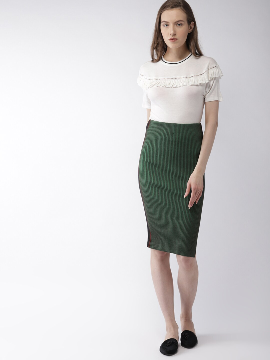



image4_4.jpg
Full Pose Image


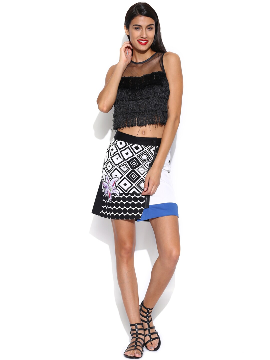



image3_2.jpg
Not a Full Pose Image


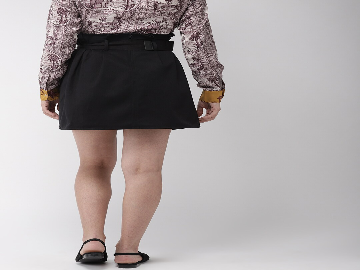



image3_0.jpg
Not a Full Pose Image


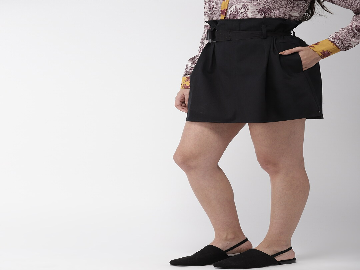



image2_0.jpg
Not a Full Pose Image


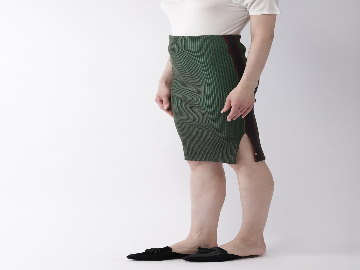



image4_1.jpg
Not a Full Pose Image


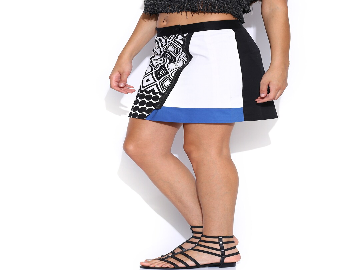



image2_2.jpg
Not a Full Pose Image


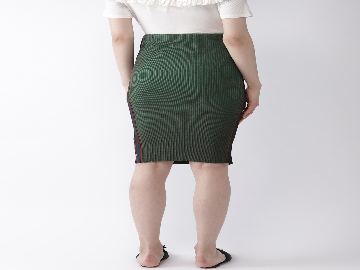



image2_4.jpg
Not a Full Pose Image


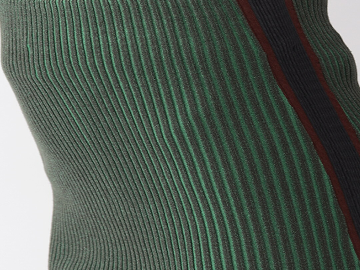



image4_3.jpg
Not a Full Pose Image


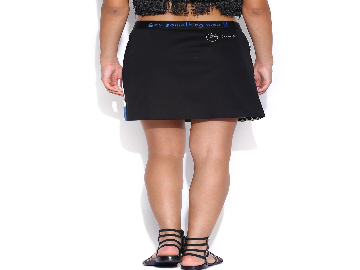



image4_2.jpg
Not a Full Pose Image


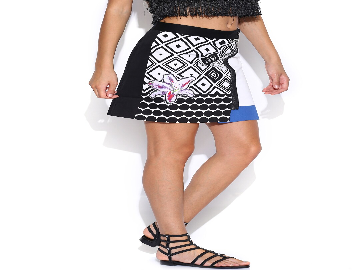



image3_3.jpg
Full Pose Image


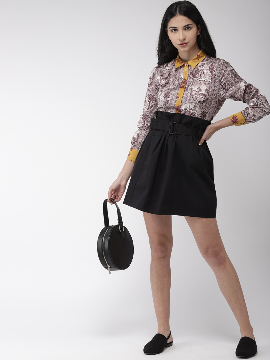



image2_1.jpg
Not a Full Pose Image


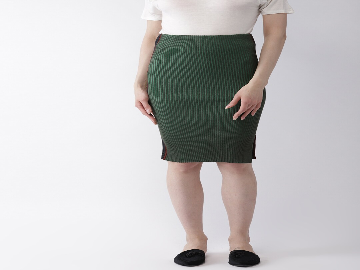



image3_1.jpg
Not a Full Pose Image


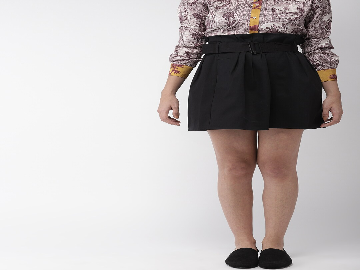

In [12]:
for i in li:
  print('='*50)
  print(i)
  #print('\n')
  a = detect_pose(i,0)
  if a==1:
    print("Full Pose Image")
    frame = cv2.imread(i, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    frame = cv2.resize(frame,(270,360))
    cv2_imshow(frame)
    print('='*50)
    print('\n')
  if a==0:
    print("Not a Full Pose Image")
    frame = cv2.imread(i, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    frame = cv2.resize(frame,(360,270))
    cv2_imshow(frame)
    print('='*50)
    print('\n')



In [ ]:
'''
Image that are detected as full pose images will be passed to second object localization module training. We will be using HrNet as 
final model because it is giving good results on our dataset.
'''